# From Zero to AlexNet

This notebook is going to start with a simple neural network, and then make a series of enhancements to improve the networks's performance. By the end of this notebook, we will have constructed the AlexNet network, which was considered a major breakthrough in computer vision when published in 2012. Many of the ideas of that network are still in use today.

Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. Commun. ACM 60, 6 (June 2017), 84–90. [https://doi.org/10.1145/3065386](https://doi.org/10.1145/3065386)


In [71]:
# import statements
from IPython.display import clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.transforms import Lambda, ToTensor

## The data set

Before we get to AlexNet, we're going to start with a simple data set, much simpler than the one used in AlexNet. The reason for using a different data set for starting is mostly performance. The data set used for AlexNet was quite large, and it's overkill for the initial models we'll build. We'll move to the full data set later, and keep tweaking from there.

In [61]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

full_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

train_size = 50000
validation_size = 10000
train_data, validation_data = random_split(full_training_data, [train_size, val_size])

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=64,  # Number of samples per batch
    shuffle=True    # Shuffle training data
)

validation_loader = DataLoader(
    dataset=validation_data,
    batch_size=64,  # Number of samples per batch
    shuffle=True    # Shuffle training data
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=False  # No need to shuffle test data
)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(validation_data)}")
print(f"Number of test samples: {len(test_data)}")

Using mps device
Number of training samples: 50000
Number of validation samples: 10000
Number of test samples: 10000


Let's take a peak at what the data looks like. Each feature is a 28x28 grayscale image. Each label is a value from 0 to 9, representing things like "Dress" and "Bag".

Text(0.5, 1.0, 'Sneaker')

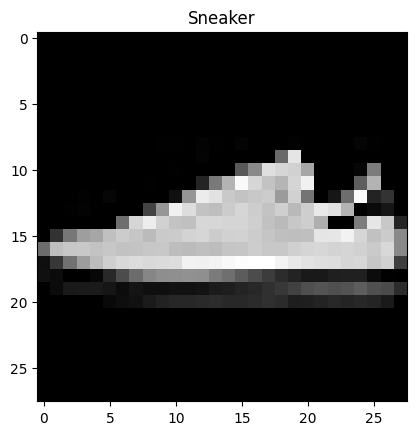

In [33]:
img, label = training_data[6]
plt.imshow(img.squeeze(), cmap="gray")
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
plt.title(labels_map[label])

## Linear Regression

The simplest neural network we can create is linear regression. Each 28x28 image gets converted to a length 784 vector $x$, with each value corresponding to a single pixel value. These are the inputs to the neural network. Each label gets converted to a length 10 vector $y$, where each value is zero except for the index corresponding to the label. That value is one. This encoding scheme is known as *one-hot encoding*. The model we then use is

$$
y = W^T x + b
$$

$W$ and $b$ are the parameter of the model that the neural net estimates. $W$ is length 784x10 vector of parameters, and $b$ is a length 10 vector of biases.

In [46]:
input_size = 28 * 28
output_size = 10

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

linear_model = LinearRegression(input_size, output_size)
linear_model.to(device)
print(linear_model)

LinearRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


## Stochastic Gradient Descent

[Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is an optimization technique used in machine learning to train models by minimizing a *loss function*. Instead of using the entire dataset at once, SGD updates the model's parameters (its weights) by computing gradients based on smaller subsets of data called batches. The size of each batch, known as the *batch size*, determines how many data points are used per update. An *epoch* is one complete pass through the entire dataset. The size of each step taken during the optimization process is controlled by the *learning rate*, which determines how much the parameters are adjusted in response to the gradient. To improve convergence, *momentum* is often added, which helps the optimization process move faster by maintaining some influence from the previous update, smoothing out the learning process. *Weight decay* is a regularization technique that discourages overly large weights by adding a small penalty to the loss function, which helps prevent overfitting. Together, these concepts allow SGD to efficiently learn from data and adjust the model to perform better on unseen examples.

The standard loss function for linear regression is the *mean square error (MSE)*. For a set of labels $\{y_1, \ldots, y_n\}$, and an estimated set of of labels $\{\hat{y}_1, \ldots, \hat{y}_n\}$, the MSE is

$$
MSE(\{y_1, \ldots, y_n\}, \{\hat{y}_1, \ldots, \hat{y}_n\}) = \frac{1}{nd} \sum_{i=1}^n \| y_i - \hat{y}_i \|^2.
$$

Here $n$ is the batch size, and $d$ is the number of output dimensions.


Epoch: 40 / 40 

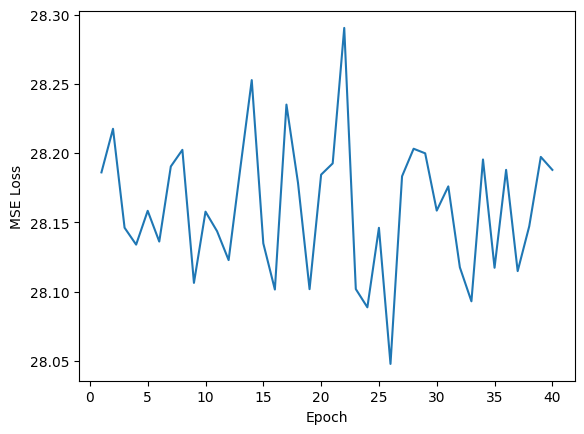

In [92]:
epochs = 40
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005

def train_model(model, train_loader):
    model.train()

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    x = np.arange(1, epochs + 1)
    y = np.zeros(epochs)

    print("Epoch:  0 / 40 ", end="\r")
    
    for epoch in range(epochs):
        epoch_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        y[epoch] = epoch_loss
        print(f"Epoch: {epoch + 1:2} / 40", end = "\r")

    return (x, y)

(x, y) = train_model(linear_model, train_loader)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
plt.show()

Before we even see how well this model performs, this loss function tells us something is wrong with the model, because with each epoch the loss should be improving, but this loss function is just a bunch of random oscillations in roughly the same range. This can have many causes, but one cause is a learning rate that's too high, causing the model to overshoot the minimum.

## Dynamic Learning Rate

One difference between this appraoch and AlexNet, is that in AlexNet, they adjusted the learning rate dynamically. In particular, whenever the loss failed to improve epoch-over-epoch, they divided the learning rate by 10. Let's try that and see if that helps with convergence.

Epoch: 40 / 40 

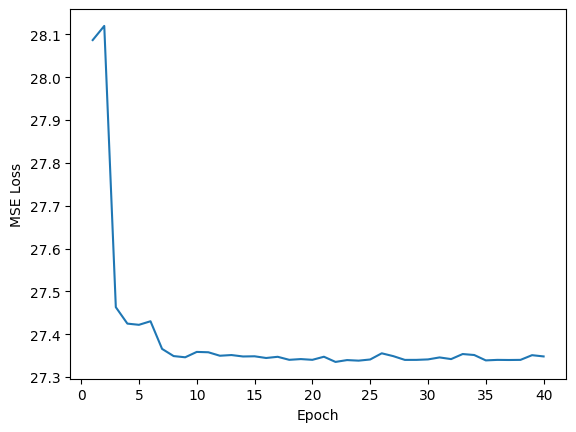

In [93]:
def train_model(model, train_loader):
    model.train()

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    x = np.arange(1, epochs + 1)
    y = np.zeros(epochs)

    print("Epoch:  0 / 40 ", end="\r")

    last_loss = float('inf')
    
    for epoch in range(epochs):
        epoch_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        y[epoch] = epoch_loss
        print(f"Epoch: {epoch + 1:2} / 40", end = "\r")

        if epoch_loss >= last_loss:
            # Reduce learning rate by a factor of 10 if loss didn't improve
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10
        last_loss = epoch_loss

    return (x, y)

(x, y) = train_model(linear_model, train_loader)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
plt.show()

This dampened the oscillations quite a bit, and even helped lower the training loss.

Now we'll look at how well this model performs on our validation data. Note that for a given input, our model can output any value in $\mathbb{R}^10$. Each label however is always a length 10 vector of zeros and ones, with a single value equal to one. To turn our regression model into a classifier, we need to transform our output $y_{pred}$ to $\hat{y}_{pred}$, where:

$$
\hat{y}_{pred}[i] = \begin{cases}
1, & i = \mathop{\mathrm{argmax}} \{i \in 1, \ldots, 10 \mid  y_{pred}[i]\}\\
0, & \mathrm{else}
\end{cases}
$$

Then we evaluate the model based on what percentage of the time it accurately predicted the output:

In [113]:
def evaluate_model_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            max_indices = torch.argmax(outputs, dim=1)
            predicted = torch.zeros_like(outputs)
            predicted.scatter_(1, max_indices.unsqueeze(1), 1)
            total += labels.size(0)
            correct += (predicted == labels).all(dim=1).int().sum().item()
    accuracy = correct / total
    return accuracy

accuracy = evaluate_model_accuracy(linear_model, validation_loader)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 82.63%


This accuracy, while better than a coin toss, is pretty "meh". Let's start tweaking this model to see if we can improve the accuracy.

## Softmax Regression

Before we go any further, let's clean up the model a bit, to account for the fact that we are building a classifier using regression. In our current model, the output can be any number in $\mathbb{R}^10$, but it would be nice if we could interpret the outputs as probabilities. If we apply the *softmax* function to each output while we train the model, we can do just that. 

The softmax function is a mathematical transformation often used in machine learning to convert a vector of raw scores (logits) into a vector of probabilities, where each value lies between 0 and 1, and the total sum of the probabilities is 1. For a given input vector $y$, the softmax function is defined as 
$$
\text{softmax}(y_i) = \frac{e^{y_i}}{\sum_{j=1}^n e^{y_j}}
$$
This ensures that higher scores correspond to higher probabilities while maintaining relative magnitudes. Softmax is commonly used in the output layer of classification models, especially in multi-class problems, to represent the model's confidence in each class. It is also differentiable, making it compatible with gradient-based optimization algorithms like backpropagation.

In [114]:
class SoftmaxModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftmaxModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.softmax(x)
        return x

softmax_model = SoftmaxModel(input_size, output_size)
softmax_model.to(device)
print(softmax_model)

SoftmaxModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


Before we train the model, we're going to change the loss function, to take advantage of the fact that our outputs represent probablities. We'll use the *cross-entropy loss* for this.

Cross-entropy loss is a widely used loss function for classification tasks, particularly in machine learning models that output probabilities, such as those using softmax activation. It measures the difference between the predicted probability distribution and the true distribution of the labels. For a single data point, the cross-entropy loss is defined as:
$$
-\sum_{i} y_i \log(\hat{y}_i),
$$
where $y_i$ is the true label (1 for the correct class and 0 otherwise), and $\hat{y}_i$ is the predicted probability for class $i$. Intuitively, it penalizes predictions that assign low probabilities to the correct class, with higher penalties for greater mismatches between the predicted and true distributions. Cross-entropy loss is differentiable, making it suitable for optimization in deep learning frameworks, and is commonly paired with a softmax output layer in multi-class classification problems.

Now we're ready to adapt our training method.

Epoch: 40 / 40 

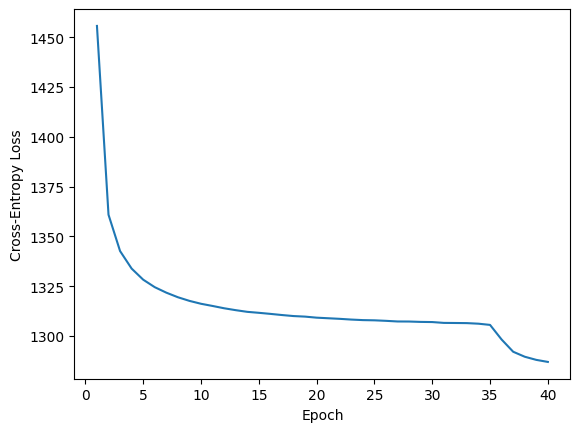

In [115]:
def train_model(model, train_loader):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    x = np.arange(1, epochs + 1)
    y = np.zeros(epochs)

    print("Epoch:  0 / 40 ", end="\r")

    last_loss = float('inf')
    
    for epoch in range(epochs):
        epoch_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        y[epoch] = epoch_loss
        print(f"Epoch: {epoch + 1:2} / 40", end = "\r")

        if epoch_loss >= last_loss:
            # Reduce learning rate by a factor of 10 if loss didn't improve
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10
        last_loss = epoch_loss

    return (x, y)

(x, y) = train_model(softmax_model, train_loader)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy Loss")
plt.show()

Now let's measure the accuracy of this model as a predictor:

In [116]:
accuracy = evaluate_model_accuracy(softmax_model, validation_loader)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 84.29%


While there was a slight accuracy boost from this, we're cleary going to have to do more.

## Hidden Layers with ReLU

## Convolutional Layers

## Max Pooling

## Overlapping Max Pooling

## Data Augmentation

## Dropout

## Adaptive Learning Rate

## A Larger Model

## A Larger Dataset